# Pulsations

In [56]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [41]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

The pulsations are represented as arrays of amplitude (percentage of the radius), which is calculated as a function of time. The user passes in parameters for the Fourier series representing this function:

$A = D + \sum_{n=1}^N cos(\frac{n}{P}t_n-\phi_n)$

In [42]:
m = IcosphereModel.construct(1000, 1., 1.,
                             bb.to_parameters(), bb.parameter_names)
m = add_pulsation(m, 0, 0, 1., jnp.array([[0.1, 0.]]), pulsation_angles=jnp.array([0.]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


As in the case of any modifications, we have to call the ```evaluate``` function to obtain meshes which have the modified parameters.

In [43]:
TIMESTAMPS = jnp.linspace(0., 2., 100)
mps = [evaluate_pulsations(m, t) for t in tqdm(TIMESTAMPS)]

100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


## Spectrum emulation

Let's calculate the spectrum in a broad range of wavelengths.

In [44]:
vws = jnp.linspace(100., 40000., 1000)
specs = [simulate_observed_flux(bb.intensity, mp0, jnp.log10(vws)) for mp0 in tqdm(mps)]

100%|██████████| 100/100 [00:03<00:00, 30.94it/s]


We can inspect the spectrum changing over time.

Text(0, 0.5, 'Observed Flux [erg/s/cm$^2$/$\\AA$]')

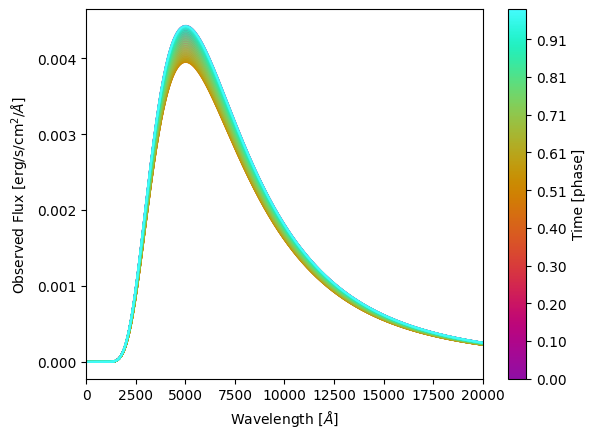

In [54]:
import cmasher as cmr
# Create a colormap based on the timestamps
cmap = cmr.tropical
# Only use the first half of the timestamps
half_timestamps = TIMESTAMPS[:len(TIMESTAMPS)//2]
half_specs = specs[:len(specs)//2]
norm = plt.Normalize(half_timestamps.min(), half_timestamps.max())
fig, ax = plt.subplots()

# Plot the spectra with colors corresponding to timestamps (only first half)
for spec, timestamp in zip(half_specs, half_timestamps):
    ax.plot(vws, spec, color=cmap(norm(timestamp)), alpha=0.5)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work correctly
cbar = plt.colorbar(sm, ax=ax, ticks=half_timestamps[::5])
cbar.set_label('Time [phase]')

# Set the colorbar tick labels to the timestamp values
cbar.set_ticklabels([f'{t:.2f}' for t in half_timestamps[::5]])

plt.gca().set_xlim(-10, 20000)
plt.gca().set_xlabel('Wavelength [$\AA$]')
plt.gca().set_ylabel('Observed Flux [erg/s/cm$^2$/$\AA$]')

As well as create an animation with spectra and mesh.

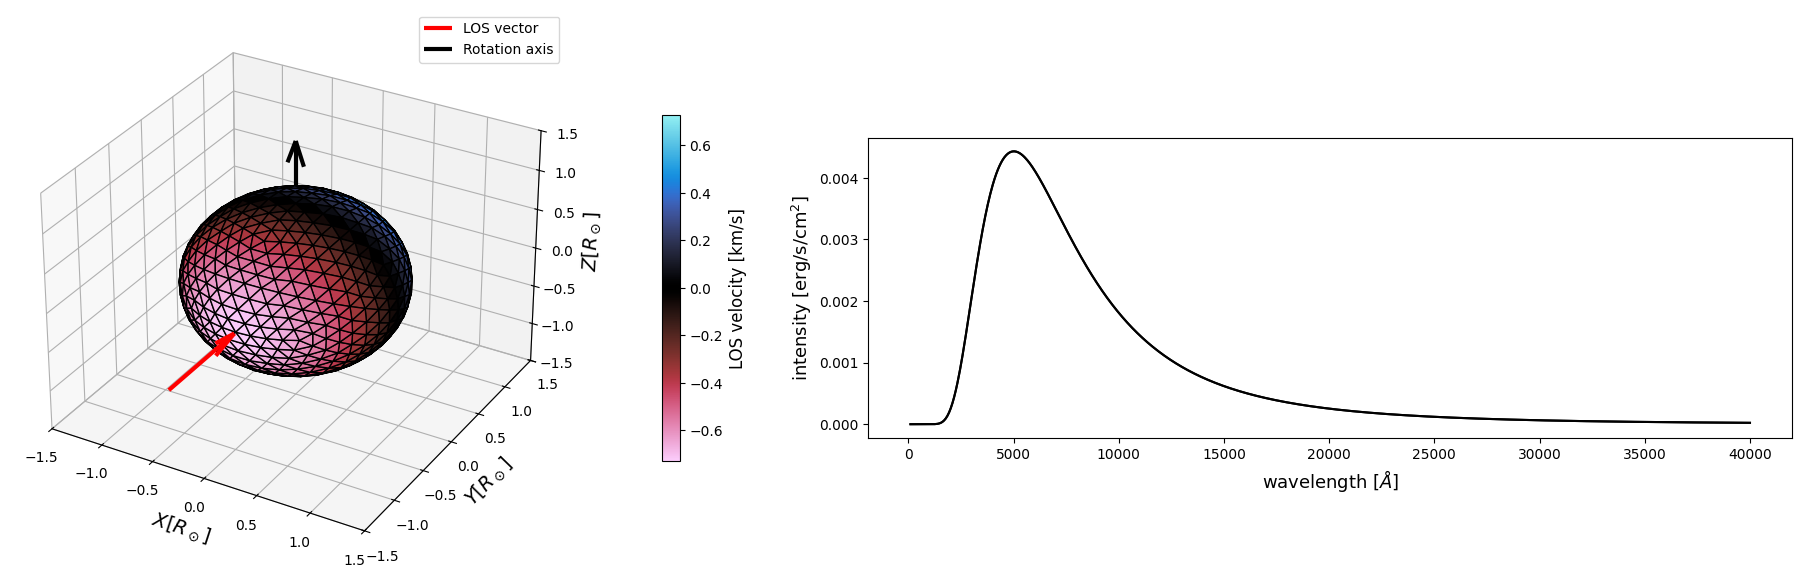

In [9]:
plot_3D_mesh_and_spectrum(mps[70], vws, specs[0], mesh_plot_kwargs=dict(property='los_velocities'));

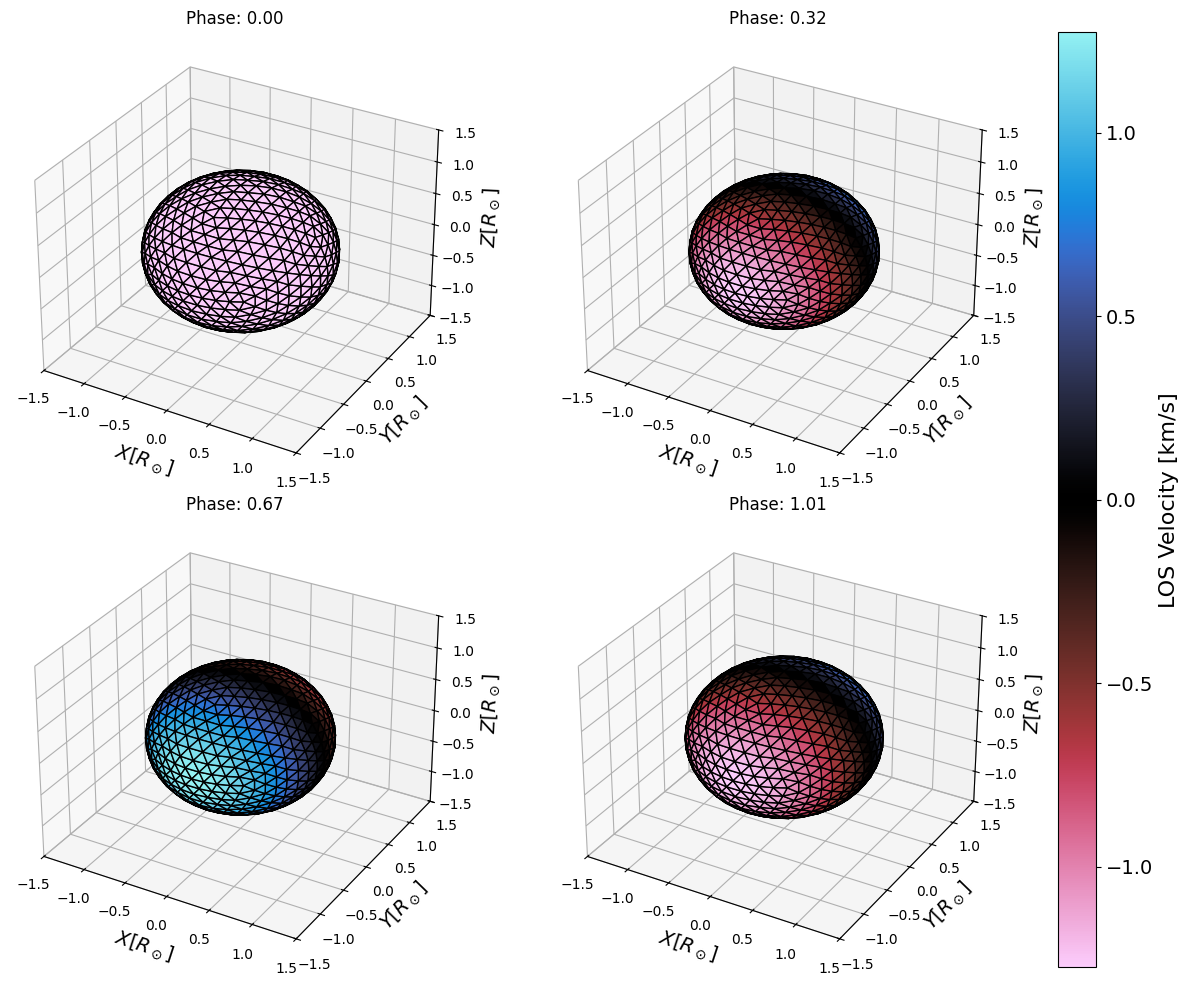

In [85]:
# Create a figure with subplots to show LOS velocities across different phases
fig = plt.figure(figsize=(12, 10))

# Select a few phases to plot
selected_indices = np.linspace(0, len(mps)//2, 4, dtype=int)
selected_phases = [TIMESTAMPS[i] for i in selected_indices]

# Create a colormap for the different phases
cmap = cmr.tropical
norm = plt.Normalize(min(selected_phases), max(selected_phases))

# Create a grid for the plots and colorbar - make colorbar column extremely thin
gs = fig.add_gridspec(2, 21)  # Increased from 11 to 21 columns for even finer control

# Create subplots for each phase
for i, (idx, phase) in enumerate(zip(selected_indices, selected_phases)):
    # Calculate row and column position
    row = i // 2
    col = i % 2
    
    # Create subplot - each plot takes 10 columns
    ax = fig.add_subplot(gs[row, col*10:(col+1)*10], projection='3d')
    
    # Plot the mesh with LOS velocities
    fig, sc = plot_3D(mps[idx], property='los_velocities', axes=(fig, ax), update_colorbar=False, draw_rotation_axis=False, draw_los_vector=False)
    
    # Add title with phase information
    ax.set_title(f'Phase: {phase:.2f}')

# Add a separate axis for the colorbar (make it extremely thin)
cax = fig.add_subplot(gs[:, -1])  # Just use the last column for colorbar
cax.set_position([0.95, 0.15, 0.002, 0.7])  # Reduced width from 0.005 to 0.002

# Get the actual min and max LOS velocities from the mesh
min_vel = min(mps[idx].los_velocities.min() for idx in selected_indices)
max_vel = max(mps[idx].los_velocities.max() for idx in selected_indices)
sm = plt.cm.ScalarMappable(cmap='cmr.redshift_r', norm=plt.Normalize(min_vel, max_vel))
sm.set_array([])  # Dummy array for the colorbar
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('LOS Velocity [km/s]', fontsize=16)
# Increase the fontsize of the colorbar ticklabels
cbar.ax.tick_params(labelsize=14)


# Add a main title
#plt.suptitle('Line-of-Sight Velocities Across Different Pulsation Phases', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95, right=0.95)  # Adjusted to accommodate thinner colorbar


## Photometric time series

In [19]:
from spice.spectrum.filter import JohnsonCousinsU, JohnsonCousinsB, JohnsonCousinsV, Bolometric, GaiaG
from spice.spectrum.spectrum import AB_passband_luminosity, luminosity

Having synthetic spectra calculated, we can now calculate passband luminosities at $d=10$ pc.

In [20]:
luminosities = np.array([luminosity(bb.flux, mps1, vws) for mps1 in mps])

filters = [JohnsonCousinsU(), JohnsonCousinsB(), JohnsonCousinsV(), Bolometric(), GaiaG()]
passband_lums = [np.array([AB_passband_luminosity(f, vws, flux[:, 0]) for flux in specs]) for f in filters]

Let's compare that with the theoretical luminosity gain.

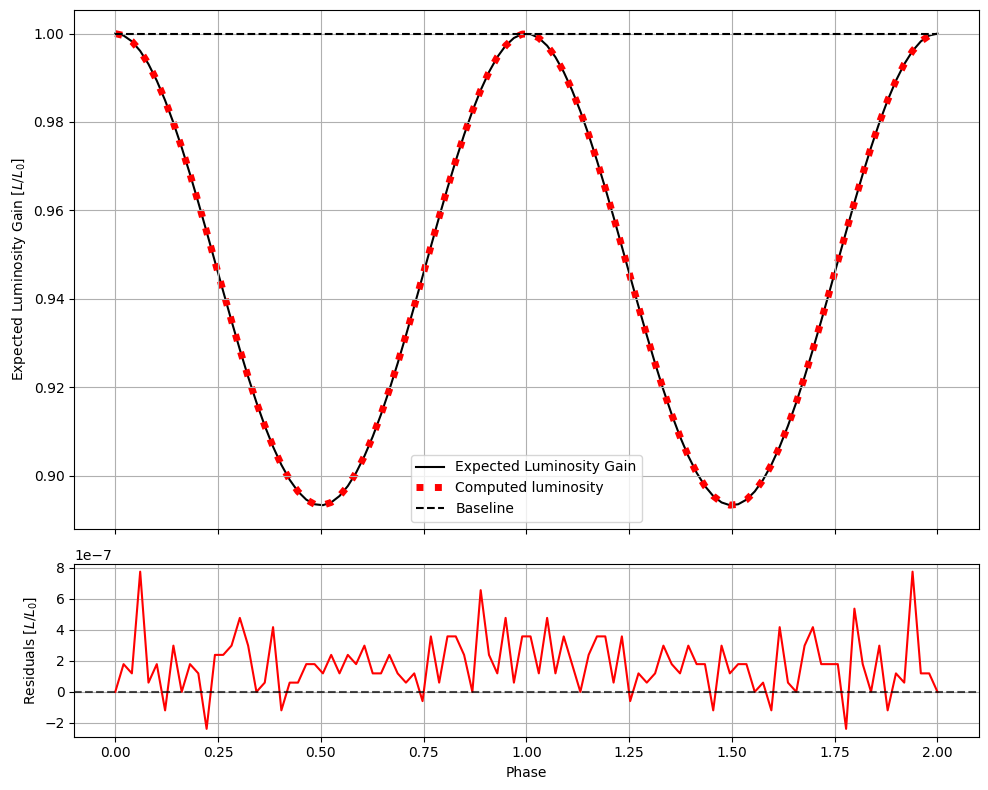

Max residual between expected luminosity gain and luminosities: 0.0000007749%


In [18]:
start_radius = jnp.mean(mps[0].radii)
mean_radii = np.array([jnp.mean(mps0.radii) for mps0 in mps])
expected_luminosity_gain = [(radius / start_radius)**2 for radius in mean_radii]
normalized_luminosities = luminosities/jnp.max(luminosities)

# Calculate phase from timestamps (assuming one full cycle in the data)
phases = TIMESTAMPS / 1.
# Create figure with two subplots (main plot and residual)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Main plot
ax1.plot(phases, expected_luminosity_gain, color='black', zorder=0, label='Expected Luminosity Gain')
ax1.plot(phases, normalized_luminosities, color='red', linestyle='dotted', linewidth=5., zorder=1, label='Computed luminosity')
ax1.plot(phases, [1] * len(phases), 'k--', label='Baseline')
ax1.set_ylabel('Expected Luminosity Gain [$L$/$L_0$]')
ax1.legend()
ax1.grid(True)

# Residual plot
residuals = np.array(expected_luminosity_gain) - normalized_luminosities
ax2.plot(phases, residuals, color='red')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.7)
ax2.set_xlabel('Phase')
ax2.set_ylabel('Residuals [$L$/$L_0$]')
ax2.grid(True)

plt.tight_layout()
plt.show()

max_luminosity_gain = max(np.abs(residuals))
print(f"Max residual between expected luminosity gain and luminosities: {max_luminosity_gain:.10f}%")

We can also calculate color indices based on the synthetic photometry.

In [21]:
# [JohnsonCousinsU(), JohnsonCousinsB(), JohnsonCousinsV(), Bolometric(), GaiaG()]

U_phot, B_phot, V_phot, bolometric, G_phot = passband_lums

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


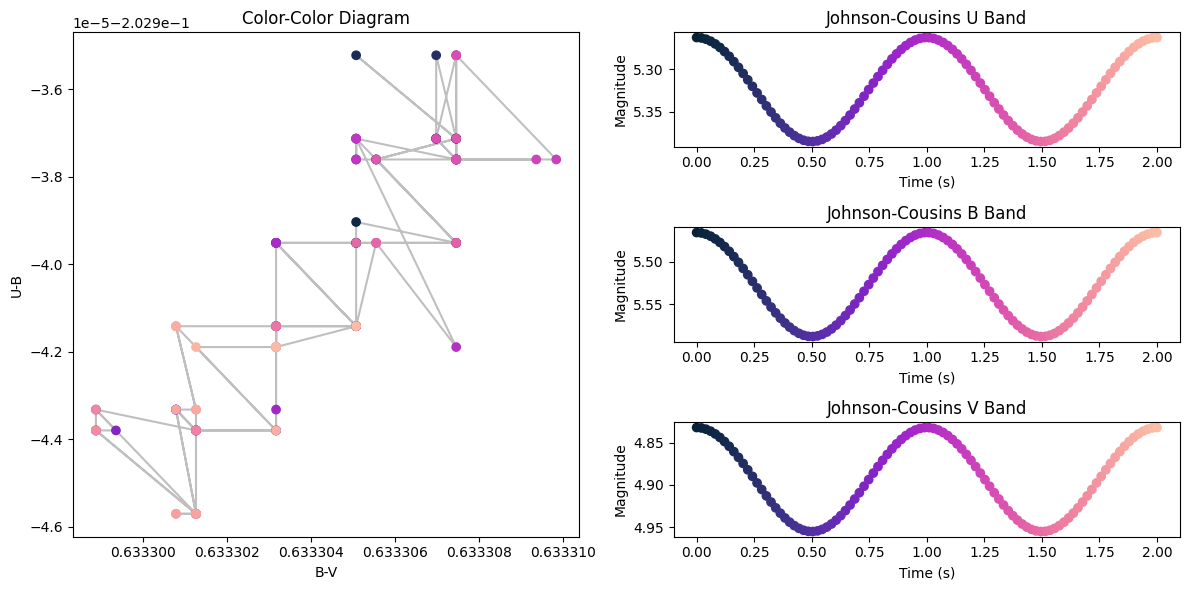

In [86]:
import matplotlib.gridspec as gridspec
import cmasher as cmr

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)
# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5, zorder=0, color='gray')
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='cmr.bubblegum', zorder=1)
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')


# # Add colorbar to show time progression
# cbar = plt.colorbar(ax_color.collections[0], ax=ax_color, label='Time (s)')

# Use scientific notation for tick labels if values are very small
# ax_color.ticklabel_format(useOffset=False, style='sci', scilimits=(-4, 4), axis='both')
# ax_color.grid(True, linestyle='--', alpha=0.7)

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['Johnson-Cousins U Band', 'Johnson-Cousins B Band', 'Johnson-Cousins V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    #ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='cmr.bubblegum', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()

The color does barely change (the tiny changes are the result of Doppler shifts causing some of the intensity to "fall outside" of the filters), as expected from the temperature-insensitive toy model we employed. In reality, the temperature will change while the star is pulsating, so this is a highly unrealistic case.

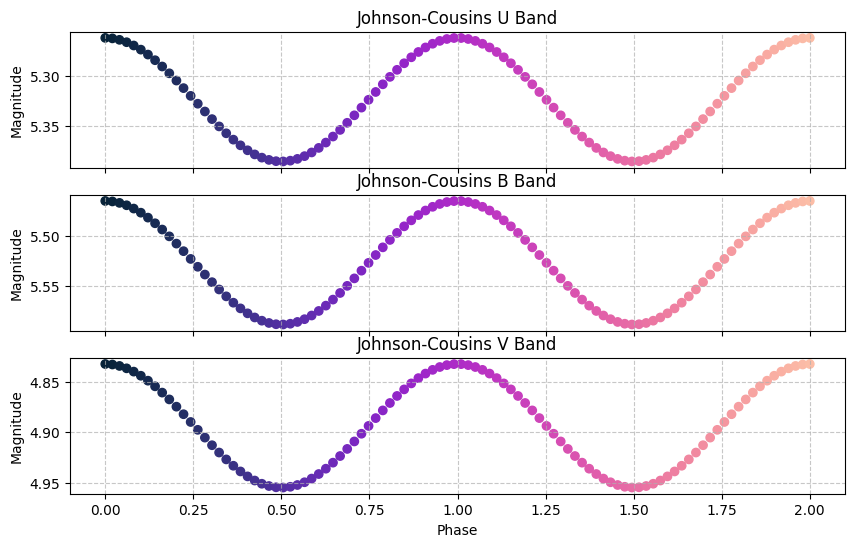

In [92]:
# Plot just the magnitude changes over time
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
ax[0].scatter(TIMESTAMPS, U_phot, label='U Band', c=TIMESTAMPS, cmap='cmr.bubblegum')
ax[1].scatter(TIMESTAMPS, B_phot, label='B Band', c=TIMESTAMPS, cmap='cmr.bubblegum')
ax[2].scatter(TIMESTAMPS, V_phot, label='V Band', c=TIMESTAMPS, cmap='cmr.bubblegum')
ax[0].set_title('Johnson-Cousins U Band')
ax[1].set_title('Johnson-Cousins B Band')
ax[2].set_title('Johnson-Cousins V Band')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[2].set_xlabel('Phase')
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Magnitude')
ax[2].set_ylabel('Magnitude')
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[2].grid(True, linestyle='--', alpha=0.7)


# Frequency analysis

Lastly, let's perform a frequency analysis to recover the pulsation period from the synthetic photometry timeseries.

In [23]:
TIMESTAMPS_LONG = np.linspace(0, 100, 1000)

mps_long = [evaluate_pulsations(m, t) for t in TIMESTAMPS_LONG]
specs_long = [simulate_observed_flux(bb.intensity, mp0, jnp.log10(vws)) for mp0 in tqdm(mps_long)]

U_phot_long, B_phot_long, V_phot_long, bolometric_long, G_phot_long = [np.array([AB_passband_luminosity(f, vws, flux[:, 0]) for flux in specs_long]) for f in filters]

# Calculate color indices for the longer timeseries
U_B_long = U_phot_long - B_phot_long
B_V_long = B_phot_long - V_phot_long

100%|██████████| 1000/1000 [00:36<00:00, 27.39it/s]


In [24]:
from astropy.timeseries import LombScargle

frequency = np.linspace(1/25, 5, 10000)
power = LombScargle(TIMESTAMPS_LONG[10:], U_phot_long[10:]).power(frequency)

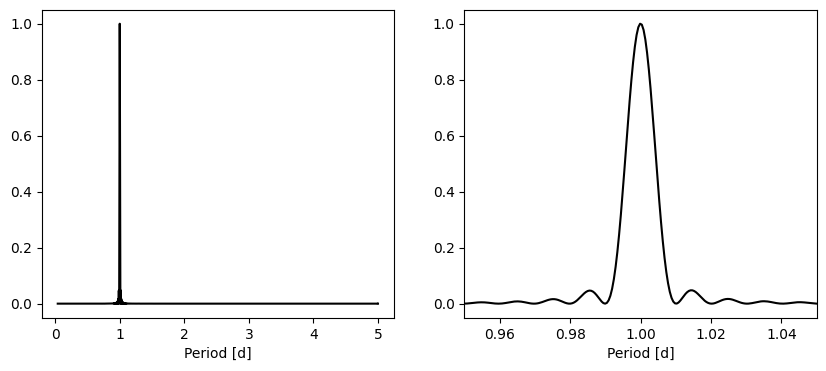

In [25]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].plot(frequency, power, color='black');
ax[0].set_xlabel('Period [d]');
ax[1].plot(frequency, power, color='black');
ax[1].set_xlabel('Period [d]');
ax[1].set_xlim(0.95, 1.05);

In [26]:
1/frequency[np.argmax(power)]

1.0001440351445754

## Tilted axis

Pulsations can be defined with a different axis than the rotation axis.

In [81]:
m = IcosphereModel.construct(1000, 1., 1.,
                             bb.to_parameters(), bb.parameter_names)
untilted_m = add_pulsation(m, 0, 1, 2., jnp.array([[1e-1, 0.]]))
tilted_m = add_pulsation(m, 0, 1, 2., jnp.array([[1e-1, 0.]]), pulsation_axes=jnp.array([0., 1., 0.]), pulsation_angles=jnp.array([45.]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:225: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
